In [5]:
from tahoe import execute_async
import pandas as pd
import json

In [6]:
execute_async("""SELECT COUNT(*) FROM sweeper.attribute_extraction_events WHERE action=4""")

[(17045,)]

In [7]:
res = execute_async("""SELECT task_id, extraction_result, dt, hr FROM sweeper.attribute_extraction_events WHERE action=4""")

In [8]:
df = pd.DataFrame(res)

In [9]:
df.columns = ['task_id', 'extraction_result', 'dt', 'hr']

In [10]:
df

,task_id,extraction_result,dt,hr
0,product_attribution_md_cc3ef95ad4d63fa7b5bc741...,"{""Boot Opening (Include Unit of Measure)"": [""N...",2023-03-15,17
1,product_attribution_md_0987b0db49df0d1384285af...,"{""Age Range Description"": [""Adult""], ""Use"": [""...",2023-04-04,19
2,product_attribution_md_e0421d594562cdc37f13f05...,"{""Item Weight (Include Unit of Measure)"": [""no...",2023-04-04,19
3,product_attribution_md_a5f75fd6a596d3b9bddd585...,"{""Item Weight (Include Unit of Measure)"": [""no...",2023-04-04,19
4,product_attribution_md_499d6a5847f613af7e4d390...,"{""Styles"": [""Not Sure""], ""Theme"": [""Not Sure""]...",2023-04-04,19
...,...,...,...,...
17040,product_attribution_md_a29ddc3691f59818575abad...,"{""Gear Ratio"": [""Not Sure""], ""Alpha Size"": [""N...",2023-03-16,13
17041,product_attribution_md_fa9cc424610c07160295ad9...,"{""Brand Name"": [""Not Sure""], ""Scent"": [""Not Su...",2023-03-16,13
17042,product_attribution_md_a29fb1de9dd7e7b5b90e706...,"{""Theme"": [""Not Sure""], ""Brand Name"": [""Not Su...",2023-03-16,13
17043,product_attribution_md_2c5856e446359edb52ddcf2...,"{""Primary Color"": [""Black""], ""Certifications"":...",2023-03-16,13


In [11]:
df_orig = pd.read_json('input/product_attr_extract_md_03252023.json', lines=True)

In [12]:
len(df_orig)

26066

In [13]:
df_merge = df_orig.merge(df, on='task_id', how='inner')

In [14]:
len(df_merge), len(set(df_merge.task_id))

(16047, 16047)

<Axes: ylabel='category_path'>

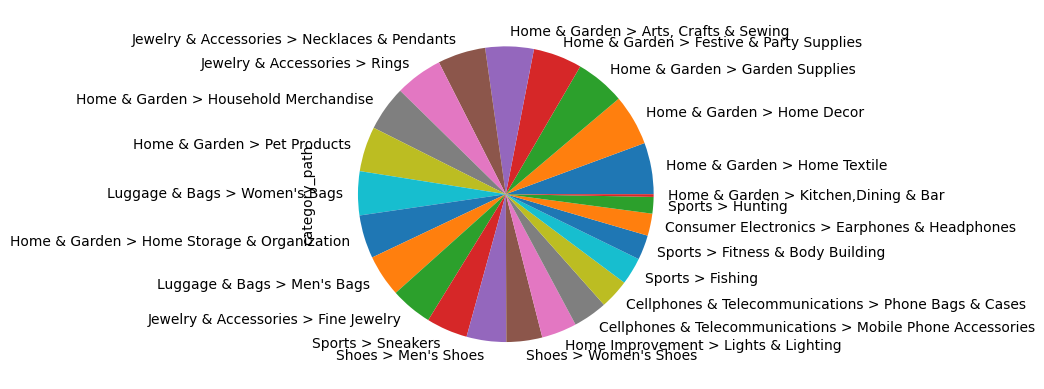

In [15]:
df_merge.category_path.apply(lambda x: ' > '.join(x.split(' > ')[:2])).value_counts().plot.pie()

In [113]:
rec = df_merge.sample(1).to_dict('records')[0]
rec2 = df_merge.sample(1).to_dict('records')[0]

In [123]:
human_result = json.loads(rec['extraction_result'])
human_result2 = json.loads(rec2['extraction_result'])

In [124]:
def clean_human_result(d):
    for k in d:
        if len(d[k]) > 0 and d[k][0].strip().lower() == 'not sure':
            d[k] = []

In [125]:
clean_human_result(human_result)
clean_human_result(human_result2)

In [126]:
human_result

{'Item Weight (Include Unit of Measure)': [],
 'Styles': [],
 'Theme': ['Butterflies'],
 'Model or Model Number': [],
 'Brand Name': [],
 'Stone Creation Method': [],
 'Chain Type': [],
 'Shape': ['Other Shape'],
 'Occasion & Lifestyle': ['Anniversary', 'Party'],
 'Side Stone': ['Rhinestone'],
 'Department': ['Women'],
 'Primary Color': ['Gold'],
 'Materials': ['Alloy'],
 'Birthstone': [],
 'Size': [],
 'Item Length (Include Unit of Measure)': [],
 'Main Stone': ['Rhinestone'],
 'Item Width (Include Unit of Measure)': []}

In [127]:
human_result2

{'Styles': [],
 'Model or Model Number': [],
 'Intended Usage': [],
 'Brand Name': [],
 'Item Length (Include Unit of Measure)': ['12.2inch'],
 'Installation or Mount Compatibility': [],
 'Alpha Size': [],
 'Primary Color': [],
 'Materials': [],
 'Item Height (Include Unit of Measure)': ['17inch'],
 'Number of Tiers': [],
 'Shape': [],
 'Item Features': [],
 'Item Depth (Include Unit of Measure)': [],
 'Item Width (Include Unit of Measure)': ['12.25inch']}

# check oai quality compared to humans

In [128]:
import random

In [129]:
def sample_from_strified_list(t):
    l = eval(t)
    if len(l) > 1:
        return random.sample(l, min(3, len(l))) + ['... and more']
    else:
        return "Free text, please extract from product title and description"

In [136]:
# Note: you need to be using OpenAI Python v0.27.0 for the code below to work
import openai
title = rec['title']
desp = rec['product_description']
attrs = '\n'.join([f"{i['attribute_field']}: {sample_from_strified_list(i['category_attributevalue'])}" for i in rec['attribute_config']])
attr_template = {i['attribute_field']: [] for i in rec['attribute_config']}

title2 = rec2['title']
desp2 = rec2['product_description']
attrs2 = '\n'.join([f"{i['attribute_field']}: {sample_from_strified_list(i['category_attributevalue'])}" for i in rec2['attribute_config']])
attr_template2 = {i['attribute_field']: [] for i in rec2['attribute_config']}

msgs = [
        {"role": "system", "content": """You are a state of art NER system that extracts all attribute key value pairs from e commerce data by filling in the blank."""},
        {"role": "user", "content": f"""[title start] {title} [title end] [description start] {desp} [description end] Fill in the blank here: {json.dumps(attr_template)}"""},
        {"role": "assistant", "content": json.dumps(human_result)},
        {"role": "user", "content": f"""Do better, you are state of art. [title start] {title2} [title end] [description start] {desp2} [description end] Fill in the blank here: {json.dumps(attr_template2)}"""},
    ]
res = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=msgs,
  temperature=0,
  max_tokens=500
)

In [137]:
res

<OpenAIObject chat.completion id=chatcmpl-71odyVbbjAsoweDd97ElVeJHF7w2Z at 0x7f2cf4529db0> JSON: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "{\"Brand Name\": [], \"Model or Model Number\": [], \"Materials\": [\"Stoneware\", \"Iron\"], \"Primary Color\": [\"White\"], \"Shape\": [\"Round\"], \"Styles\": [\"Mid-Century\"], \"Alpha Size\": [], \"Installation or Mount Compatibility\": [], \"Intended Usage\": [\"Indoor\"], \"Item Depth (Include Unit of Measure)\": [], \"Item Features\": [\"Durable\"], \"Item Height (Include Unit of Measure)\": [\"17 inches\"], \"Item Length (Include Unit of Measure)\": [\"12.2 inches\"], \"Item Width (Include Unit of Measure)\": [\"12.25 inches\"], \"Number of Tiers\": [], \"Item Features\": [\"Decorative Container\"]}",
        "role": "assistant"
      }
    }
  ],
  "created": 1680667358,
  "id": "chatcmpl-71odyVbbjAsoweDd97ElVeJHF7w2Z",
  "model": "gpt-3.5-turbo-0301",
  "object": "chat.c

In [138]:
rec2['title']

'HOT Mid-Century Ceramic Planter with Stand, 17"H, White'

In [139]:
rec2['product_description']

'● This two-tone round stoneware planter is an attractive piece on its own. Combined with an iron shelf/stand, it makes a mid-century style statement in addition to holding plants. Planter and shelf can be used together or separately.\n● 100% stoneware with iron stand\n● Durable piece designed for house plants, but also stands alone as a decorative container\n● Whole planter size (include iron stand)-12.2 x 12.25 x 17 H inches. Planter size(without iron stand)-12.2 x 12.2 x 12 H inches\n● Planter does not have drainage holes.'

In [140]:
human_result2

{'Styles': [],
 'Model or Model Number': [],
 'Intended Usage': [],
 'Brand Name': [],
 'Item Length (Include Unit of Measure)': ['12.2inch'],
 'Installation or Mount Compatibility': [],
 'Alpha Size': [],
 'Primary Color': [],
 'Materials': [],
 'Item Height (Include Unit of Measure)': ['17inch'],
 'Number of Tiers': [],
 'Shape': [],
 'Item Features': [],
 'Item Depth (Include Unit of Measure)': [],
 'Item Width (Include Unit of Measure)': ['12.25inch']}

In [141]:
json.loads(res['choices'][0]['message']['content'])

{'Brand Name': [],
 'Model or Model Number': [],
 'Materials': ['Stoneware', 'Iron'],
 'Primary Color': ['White'],
 'Shape': ['Round'],
 'Styles': ['Mid-Century'],
 'Alpha Size': [],
 'Installation or Mount Compatibility': [],
 'Intended Usage': ['Indoor'],
 'Item Depth (Include Unit of Measure)': [],
 'Item Features': ['Decorative Container'],
 'Item Height (Include Unit of Measure)': ['17 inches'],
 'Item Length (Include Unit of Measure)': ['12.2 inches'],
 'Item Width (Include Unit of Measure)': ['12.25 inches'],
 'Number of Tiers': []}